In [13]:
import fastbox as fb
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.optimize import newton
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import pandas as pd
# from pysabr import Hagan2002LognormalSABR
# from pysabr import Hagan2002NormalSABR
# from pysabr import hagan_2002_lognormal_sabr as hagan2002LN
from tqdm import tqdm  
import seaborn as sns 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import SplineTransformer
import torch
import torch.nn as nn
import torch.optim as optim
np.set_printoptions(suppress=True)


$$\sigma(\mathrm{X}, \mathrm{f}) =\frac{\alpha\left[1+\left(\frac{(1-\beta)^2}{24(f X)^{1-\beta}} \alpha^2+\frac{\rho \beta v}{4(f X)^{\frac{1-\beta}{2}}} \alpha+\frac{\left(2-3 \rho^2\right) v^2}{24}\right) T\right]_z}{(f X)^{\frac{1-\beta}{2}}\left[1+\frac{(1-\beta)^2}{24}\left(\ln \frac{f}{X}\right)^2+\frac{(1-\beta)^4}{1920}\left(\ln \frac{f}{X}\right)^4\right]} \frac{z}{x(z)}$$    
$$z=\frac{v}{\alpha}(f K)^{(1-\beta) / 2} \log \frac{f}{K}$$
$$x(z)=\log \frac{\sqrt{1-2 \rho z+z^2}+z-\rho}{1-\rho}$$
For at-the-money (ATM) options, $K=f$, the volatility calculation formula is simplified to:
$$\sigma_{A T M}=\sigma(f, f)=\frac{\alpha}{f^{1-\beta}}\left(1+\left(\frac{(1-\beta)^2}{24 f^{2-2 \beta}} \alpha^2+\frac{\rho \beta v}{4 f^{1-\beta}} \alpha+\frac{\left(2-3 \rho^2\right) v^2}{24}\right) T_{e x}\right)$$

In [14]:
# a、k:strike price
# b、v_sln: initial volatility
# 1、f：forward price
# 2、s:shift
# 3、t:excerse time
# 4、beta
def lognormal_vol(k, f, t, alpha, beta, rho, volvol):
    """
    Hagan's 2002 SABR lognormal vol expansion.

    The strike k can be a scalar or an array, the function will return an array
    of lognormal vols.
    """
    # Negative strikes or forwards
    if k <= 0 or f <= 0:
        return 0.
    eps = 1e-07
    logfk = np.log(f / k)
    fkbeta = (f*k)**(1 - beta)
    a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
    b = 0.25 * rho * beta * volvol * alpha / fkbeta**0.5
    c = (2 - 3*rho**2) * volvol**2 / 24
    d = fkbeta**0.5
    v = (1 - beta)**2 * logfk**2 / 24
    w = (1 - beta)**4 * logfk**4 / 1920
    z = volvol * fkbeta**0.5 * logfk / alpha
    if abs(z) > eps:
        vz = alpha * z * (1 + (a + b + c) * t) / (d * (1 + v + w) * _x(rho, z))
        return vz
    # ATM
    else:
        v0 = alpha * (1 + (a + b + c) * t) / (d * (1 + v + w))
        return v0

def _x(rho, z):
    """Return function x used in Hagan's 2002 SABR lognormal vol expansion."""
    a = (1 - 2*rho*z + z**2)**.5 + z - rho
    b = 1 - rho
    return np.log(a / b)

In [15]:
date = '2023-08-04'
forward_price=fb.data.futures.daily(instrumentid = 'CU2310',from_date = '2023-01-01',to_date = '2023-12-31')
option_price = fb.data.futuresoptions.daily(instrumentid = 'CU2310',from_date = date,to_date = date)
option_price['weight']=option_price['vol']/option_price['vol'].groupby(level= 'call_put').sum()

Authentication has expired.

Please enter your user name and password for authentication.

Please input your user name:

 ren12345678


Please input your password:

 ········


User not authorized. Incorrect username or password.

Please enter your user name and password for authentication.

Please input your user name:

 rc-123456@sjtu.edu.cn


Please input your password:

 ········


User authorized.

In [ ]:
# Futures price on exercise date
forward=forward_price.loc[date,'settle'] # spot price
mat=(option_price.index.get_level_values('maturity')[0]-option_price.index.get_level_values('date')[0]).days
r=0.02

In [7]:
N = norm.cdf
def BS(forward, strike, mat, r, sigma, flag):
    """
    This function returns the BS price for an option on futures Flag = P or C
    We assume that sigma is yearly and r is yearly. mat is the number of days to maturity so tau = mat / 360
    """
    sign = 1
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "P":
        sign = -1
    std_dev = sigma * np.sqrt(tau)

    d1 = np.log(forward/strike) / std_dev + 0.5 * std_dev
    d2 = d1 - std_dev
    result = discount * sign * (forward * N(sign * d1) - strike * N(sign * d2))
    return result

# now for the implied volatility
# remember the put call parity
# BS(call) - BS(put) = discount * (forward - K)
# so if the strike is very high (for the put out of the money) then BS(put) is close to 0. then the corresponding call is equal to BS(call) = disount * (forward - K) - BS(put) and you search the implied vol for this call and strike
# the decision for in/out of the money is if K>forward then call if K<forward then put

def IV(forward, strike, mat, r, price, flag):
    tau = mat / 360
    discount = np.exp(- r * tau)
    # if flag == "C" and strike > forward:
    #     flag = "P"
    #     price = price - discount *(forward - strike)
    # elif flag == "P" and strike <= forward:
    #     flag = "C"
    #     price = discount *(forward - strike) + price
    
    def root_func(x):
        return BS(forward, strike, mat, r, x, flag) - price
    sigma = newton(root_func, 0.2)
    return sigma

In [8]:
votility_df = pd.DataFrame() # Recording the results of calculations
strike_price = []
votility_BS = []
flags = []
vol = []
weight = []
'''
Unsolvable volatility for deep real-money options
'''
for index in option_price.index:
    try:
        flag=index[2]
        strike=index[3]#strike price
        price=option_price.loc[index,'settle']#Option price
        vol.append(option_price.loc[index,'vol'])
        weight.append(option_price.loc[index,'weight'])
        votility=IV(forward, strike, mat, r, price, flag)
        strike_price.append(strike)
        votility_BS.append(votility)
        flags.append(flag)
    except:
        print(index)
votility_df['strike_price'] = strike_price
votility_df['votility_BS'] = votility_BS
votility_df['flags'] = flags
votility_df['vol'] = vol
votility_df['weight'] = weight
votility_df_new = pd.concat([votility_df[(votility_df['flags'] == 'C') & (votility_df['strike_price'] < forward)], votility_df[(votility_df['flags'] == 'P') & (votility_df['strike_price'] > forward)]])

In [9]:
Strikes = votility_df_new['strike_price']
Vols_BS = votility_df_new['votility_BS']
beta=0.5
# this step we will get alpha, rho, volvol
def vol_square_error(x):
    vols = [lognormal_vol(k_, forward, mat / 360, x[0], beta, x[1],
                          x[2])*100 for k_ in Strikes]
    return sum((vols - Vols_BS)**2)

initial_guess = [0.01, 0.00, 0.10]
x0 = np.array(initial_guess)
bounds = [(0.0001, None), (-0.9999, 0.9999), (0.0001, None)]
res = minimize(vol_square_error, x0, method='L-BFGS-B', bounds=bounds)
alpha, rho, volvol = res.x
votility_df_new['votility_sabr']=[lognormal_vol(k_, forward, mat / 360, alpha, beta, rho,volvol)*100 for k_ in Strikes]

In [10]:
plt.xlabel('Strike') 
plt.ylabel('Volatility') 
plt.title("Volatility Smile")
plt.plot(votility_df[votility_df['flags']=='P']['strike_price'], votility_df[votility_df['flags']=='P']['votility_BS'], 'o', label='Put')
plt.plot(votility_df[votility_df['flags']=='C']['strike_price'], votility_df[votility_df['flags']=='C']['votility_BS'], 'o', label='Call')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_sabr'],label='calibrated')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_BS'],label='bs')
plt.grid(True)  
plt.legend()
plt.show()
print("Fitted  alpha, beta, rho, volvol: ", [alpha,beta, rho, volvol])

NameError: name 'plt' is not defined

## if i take vol/vol_call and vol/vol_put as weight

In [11]:
# now i will take weight into account
Strikes = votility_df_new['strike_price']
Vols_BS = votility_df_new['votility_BS']
weight= votility_df_new['weight']
beta=0.5
# this step we will get alpha, rho, volvol
def vol_square_error(x):
    vols = [lognormal_vol(k_, forward, mat / 360, x[0], beta, x[1],
                          x[2])*100 for k_ in Strikes]
    return sum(((vols - Vols_BS)*weight)**2)

initial_guess = [0.01, 0.00, 0.10]
x0 = np.array(initial_guess)
bounds = [(0.0001, None), (-0.9999, 0.9999), (0.0001, None)]
res = minimize(vol_square_error, x0, method='L-BFGS-B', bounds=bounds)
alpha, rho, volvol = res.x
votility_df_new['votility_sabr']=[lognormal_vol(k_, forward, mat / 360, alpha, beta, rho,volvol)*100 for k_ in Strikes]

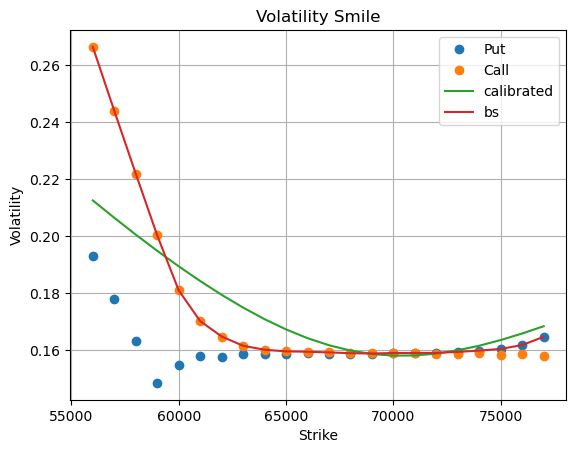

Fitted  alpha, beta, rho, volvol:  [0.41660395902888364, 0.5, -0.02925431563162881, 0.01204803359712209]


In [12]:
plt.xlabel('Strike') 
plt.ylabel('Volatility') 
plt.title("Volatility Smile")
plt.plot(votility_df[votility_df['flags']=='P']['strike_price'], votility_df[votility_df['flags']=='P']['votility_BS'], 'o', label='Put')
plt.plot(votility_df[votility_df['flags']=='C']['strike_price'], votility_df[votility_df['flags']=='C']['votility_BS'], 'o', label='Call')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_sabr'],label='calibrated')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_BS'],label='bs')
plt.grid(True)  
plt.legend()
plt.show()
print("Fitted  alpha, beta, rho, volvol: ", [alpha,beta, rho, volvol])

## if i take vol/vol.sum() as weight (weight_new= votility_df_new['vol']/votility_df_new['vol'].sum())

In [13]:
Strikes = votility_df_new['strike_price']
Vols_BS = votility_df_new['votility_BS']
weight_new= votility_df_new['vol']/votility_df_new['vol'].sum()
beta=0.5
# this step we will get alpha, rho, volvol
def vol_square_error(x):
    vols = [lognormal_vol(k_, forward, mat / 360, x[0], beta, x[1],
                          x[2])*100 for k_ in Strikes]
    return sum(((vols - Vols_BS)*weight_new)**2)

initial_guess = [0.01, 0.00, 0.10]
x0 = np.array(initial_guess)
bounds = [(0.0001, None), (-0.9999, 0.9999), (0.0001, None)]
res = minimize(vol_square_error, x0, method='L-BFGS-B', bounds=bounds)
alpha, rho, volvol = res.x
votility_df_new['votility_sabr']=[lognormal_vol(k_, forward, mat / 360, alpha, beta, rho,volvol)*100 for k_ in Strikes]

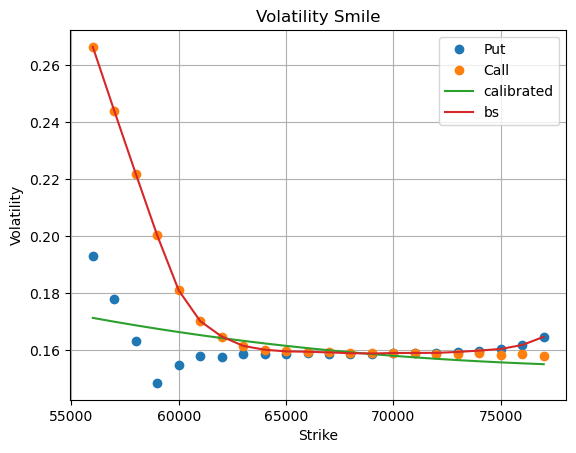

Fitted  alpha, beta, rho, volvol:  [0.4165872850756595, 0.5, -0.02087999004382881, 0.0029507506506193408]


In [14]:
plt.xlabel('Strike') 
plt.ylabel('Volatility') 
plt.title("Volatility Smile")
plt.plot(votility_df[votility_df['flags']=='P']['strike_price'], votility_df[votility_df['flags']=='P']['votility_BS'], 'o', label='Put')
plt.plot(votility_df[votility_df['flags']=='C']['strike_price'], votility_df[votility_df['flags']=='C']['votility_BS'], 'o', label='Call')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_sabr'],label='calibrated')
plt.plot(votility_df_new['strike_price'], votility_df_new['votility_BS'],label='bs')
plt.grid(True)  
plt.legend()
plt.show()
print("Fitted  alpha, beta, rho, volvol: ", [alpha,beta, rho, volvol])

## the picture of daily vol of different exercise date's options of the same future

In [15]:
id_ls = [ f'CU230{i+1}' for i in range(12)]
vol_all = pd.DataFrame()
for id in tqdm(id_ls):
    options = fb.data.futuresoptions.daily(instrumentid = id)
    if options is None:
        pass
    else:
        vol=options['vol'].groupby(level = 'date').sum()
        # may exist some 
        vol.index=(options.index.get_level_values('maturity')[0]-vol.index).days+1
        vol.name =  id
        vol_all=pd.concat([vol_all,vol],axis=1)
vol_all.loc[0,:]=0
vol_all=vol_all.sort_index()

 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:03<00:01,  2.98it/s]

Query return empty dataframe.

 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:03<00:00,  3.49it/s]

Query return empty dataframe.

 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:03<00:00,  3.85it/s]

Query return empty dataframe.

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.29it/s]


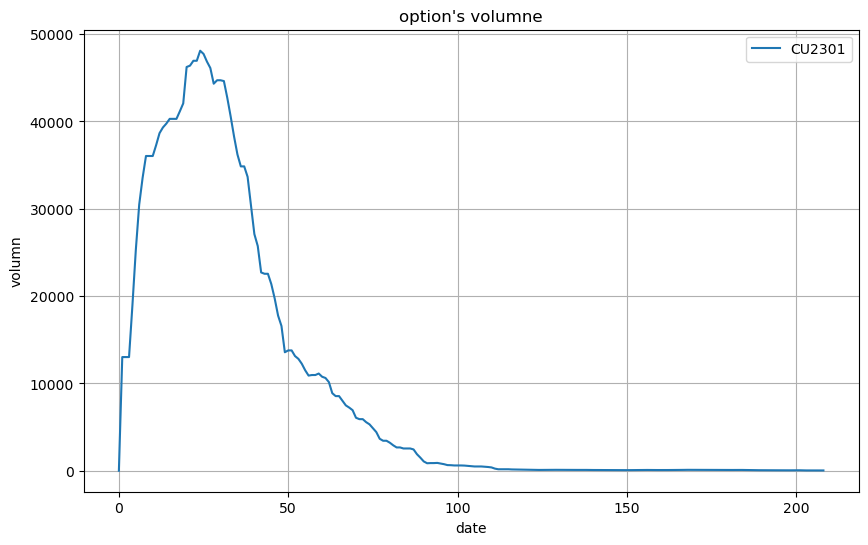

In [16]:
plt.figure(figsize=(10, 6))
col=vol_all.columns[0]
smoothed = vol_all[col].rolling(window=20,min_periods=0).mean()
plt.plot(smoothed, label=col)
plt.title("option's volumne")
plt.xlabel('date')
plt.ylabel('volumn')

plt.legend()

plt.grid(True)

plt.show()

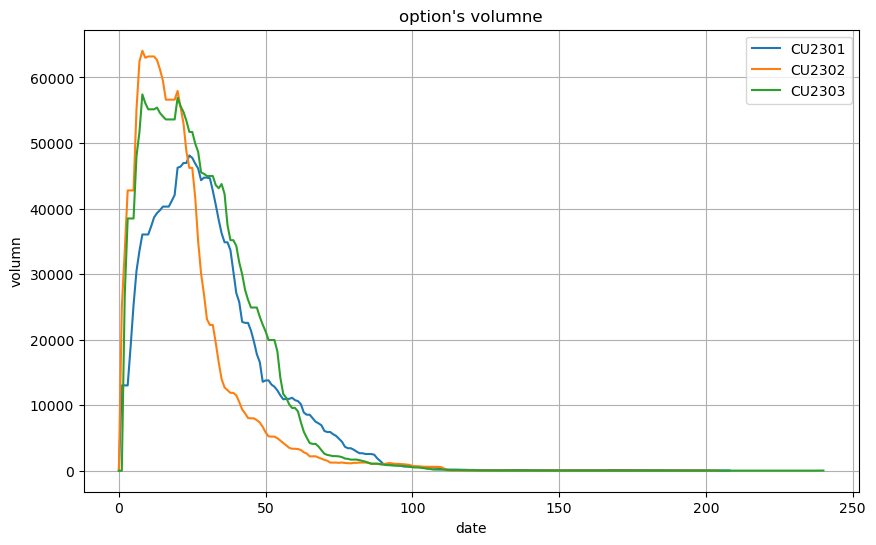

In [17]:
plt.figure(figsize=(10, 6))

for i, col in enumerate(vol_all.columns[:3]):
    smoothed = vol_all[col].rolling(window=20,min_periods=0).mean()
    plt.plot(smoothed, label=col)
plt.title("option's volumne")
plt.xlabel('date')
plt.ylabel('volumn')

plt.legend()

plt.grid(True)

plt.show()


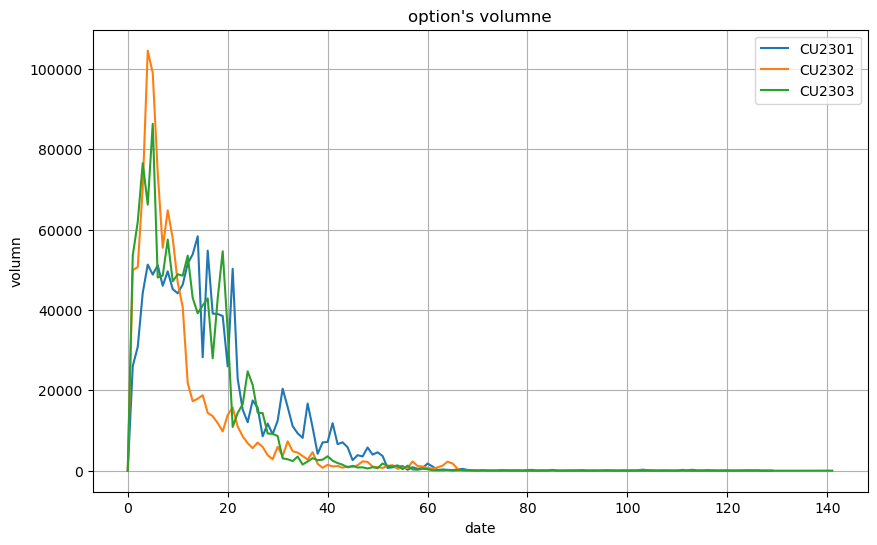

In [18]:
plt.figure(figsize=(10, 6))
for col in vol_all.columns[:3]:
    y = vol_all[col].dropna()
    x = range(len(y))
    
    plt.plot(x, y, label=col)
plt.title("option's volumne")
plt.xlabel('date')
plt.ylabel('volumn')

plt.legend()

plt.grid(True)

plt.show()

# then i will do some statistics on the relationships between volume and maturity for each of the underlying that have options 

## first for the fulture options

In [19]:
# it seems to be hard to regress if index0 = 0
try:
    vol_all.drop(0, axis=1)
except:
    pass

In [20]:
# cuppor
# Basic statistical characteristics
print(f"mean:\n{vol_all.mean()}")
print(f"std:\n{vol_all.std()}")
print(f"cor:\n{vol_all.corr(method='pearson')}")

mean:
CU2301     9489.769231
CU2302     7824.362205
CU2303     8569.563380
CU2304    14546.974790
CU2305    10412.440945
CU2306    13234.986577
CU2307    15995.451613
CU2308     9221.582857
CU2309    17340.560000
dtype: float64
std:
CU2301    16339.666597
CU2302    19112.398228
CU2303    18433.086633
CU2304    26709.254768
CU2305    20289.831385
CU2306    30351.205701
CU2307    28775.298478
CU2308    21513.595752
CU2309    30836.462909
dtype: float64
cor:
          CU2301    CU2302    CU2303    CU2304    CU2305    CU2306    CU2307  \
CU2301  1.000000  0.776567  0.912761  0.938578  0.911101  0.884059  0.939758   
CU2302  0.776567  1.000000  0.878285  0.805512  0.911747  0.863011  0.690304   
CU2303  0.912761  0.878285  1.000000  0.919310  0.928739  0.870276  0.896593   
CU2304  0.938578  0.805512  0.919310  1.000000  0.922823  0.975443  0.928445   
CU2305  0.911101  0.911747  0.928739  0.922823  1.000000  0.914517  0.863125   
CU2306  0.884059  0.863011  0.870276  0.975443  0.914517  1.

In [21]:
# it is easy to find that the volume reaches its maximum value when maturity is about to expire.
# when it reaches the maximum
print(f"max_date:\n{vol_all.idxmax()}")
# compaired to its total trade date 
print(f"compaired_date:\n{vol_all.idxmax()/vol_all.apply(lambda col: col.last_valid_index())}")

max_date:
CU2301    20
CU2302     6
CU2303     8
CU2304    12
CU2305     8
CU2306    14
CU2307    19
CU2308    12
CU2309    24
dtype: int64
compaired_date:
CU2301    0.105820
CU2302    0.032432
CU2303    0.037037
CU2304    0.066298
CU2305    0.042781
CU2306    0.063636
CU2307    0.100529
CU2308    0.045977
CU2309    0.131148
dtype: float64


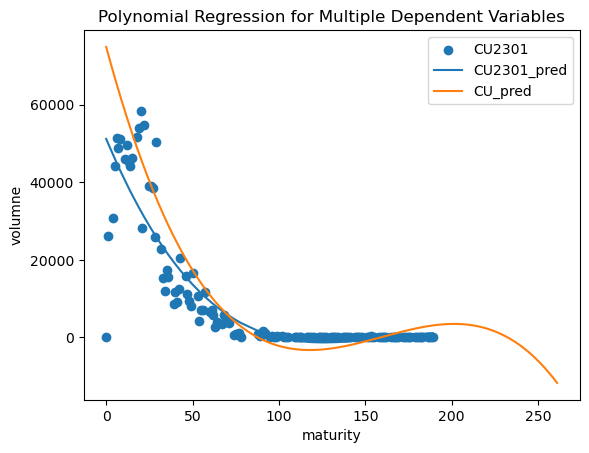

In [22]:
# then i will considerate the regression
# appearently, its is not a linear or quadratic relationship
# first i will try the polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

CU2301=vol_all.CU2301.dropna()
maturity_CU2301=np.array(CU2301.index)
all_data=pd.concat([vol_all[col] for col in vol_all.columns], axis=0).dropna()
CU=all_data.values
maturity_CU=np.array(all_data.index)


poly = PolynomialFeatures(degree=3)
maturity_CU2301_poly = poly.fit_transform(maturity_CU2301.reshape(-1, 1))
maturity_CU_poly = poly.fit_transform(maturity_CU.reshape(-1, 1))


model_CU2301 = LinearRegression()
model_CU2301.fit(maturity_CU2301_poly, CU2301)


model_CU = LinearRegression()
model_CU.fit(maturity_CU_poly, CU)

CU2301_pred = model_CU2301.predict(maturity_CU2301_poly)
CU_pred = model_CU.predict(maturity_CU_poly)
all_pred = pd.Series(CU_pred,index=maturity_CU).sort_index().drop_duplicates()

plt.scatter(maturity_CU2301, CU2301, label='CU2301')

plt.plot(maturity_CU2301, CU2301_pred, label='CU2301_pred')
plt.plot(all_pred, label='CU_pred')
plt.xlabel('maturity')
plt.ylabel('volumne')
plt.title('Polynomial Regression for Multiple Dependent Variables')
plt.legend()
plt.show()

# Obviously, the effect is not good； i will not continue the polynomial regression

In [23]:
results = []

# create function to obtain model rmse
def model_results(model_name,reg,X_train,X_test):

    # Training data
    pred_train = reg.predict(X_train)
    rmse_train = round(mean_squared_error(y_train, pred_train, squared=False),4)

    # Test data
    pred_test = reg.predict(X_test)
    rmse_test =round(mean_squared_error(y_test, pred_test, squared=False),4)

    # Save model results
    new_results = {"model": model_name, "rmse_train": rmse_train, "rmse_test": rmse_test}
    results.append(new_results)  
      
    return results;
np.set_printoptions(suppress=True)
# Dividing data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(maturity_CU, CU, test_size=0.3, random_state = 1)

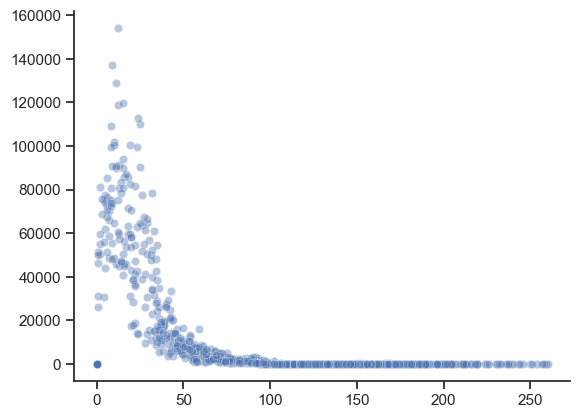

In [24]:
 # seaborn settings
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# plot
sns.scatterplot(x=X_train, y=y_train, alpha=0.4);

In [25]:
poly = PolynomialFeatures(degree=3)
alphas=np.logspace(-6, 6, 13)
reg = linear_model.RidgeCV(alphas=alphas,fit_intercept=True)
reg=reg.fit(poly.fit_transform(X_train.reshape(-1, 1)),y_train)
reg.alpha_

1000.0

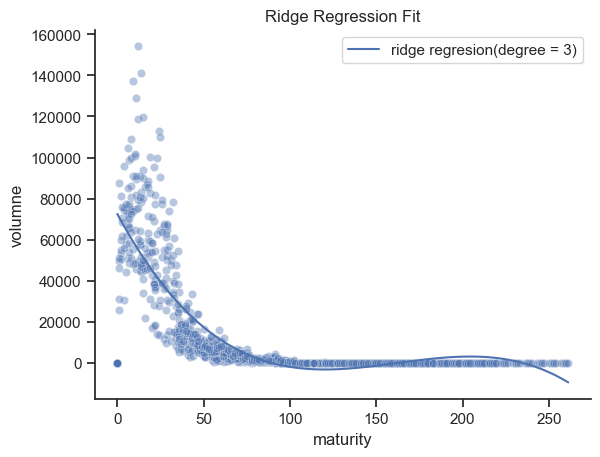

In [26]:
model_results(model_name="Ridge", reg=reg, X_train=poly.fit_transform(X_train.reshape(-1, 1)), X_test=poly.fit_transform(X_test.reshape(-1, 1)))
y_pred_train = reg.predict(poly.fit_transform(maturity_CU.reshape(-1, 1)))

all_pred = pd.Series(y_pred_train,index=maturity_CU).sort_index().drop_duplicates()

plt.plot(all_pred, label='ridge regresion(degree = 3)')
plt.xlabel('maturity')
plt.ylabel('volumne')
plt.legend()
sns.scatterplot(x=all_data.index,y=all_data.values, alpha=0.4)
plt.title('Ridge Regression Fit')
plt.show()


In [27]:
# i consider regression spline next
# use a spline wit 8 knots and 3 degrees ,and segment of the spline seems to be 0 to 30

reg = make_pipeline(
                    SplineTransformer(n_knots=8, degree=3), 
                    linear_model.RidgeCV(alphas=alphas)
                    )
reg.fit(X_train.reshape(-1,1), y_train)

Pipeline(steps=[('splinetransformer', SplineTransformer(n_knots=8)),
                ('ridgecv',
                 RidgeCV(alphas=array([      0.000001,       0.00001 ,       0.0001  ,       0.001   ,
             0.01    ,       0.1     ,       1.      ,      10.      ,
           100.      ,    1000.      ,   10000.      ,  100000.      ,
       1000000.      ])))])

In [28]:
model_results(model_name="Cubic Spline",reg=reg, X_train=X_train.reshape(-1, 1), X_test=X_test.reshape(-1, 1))

[{'model': 'Ridge', 'rmse_train': 14058.9118, 'rmse_test': 10802.2782},
 {'model': 'Cubic Spline', 'rmse_train': 10786.5065, 'rmse_test': 10087.1007}]

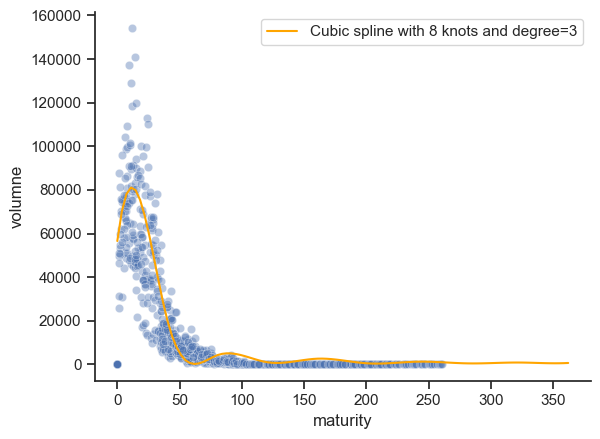

In [115]:
# Create observations
x_new = np.linspace(X_test.min(),X_test.max(), 100)
# Make some predictions
pred = reg.predict(x_new.reshape(-1,1))

sns.scatterplot(x=all_data.index,y=all_data.values, alpha=0.4)

plt.plot(x_new, pred, label='Cubic spline with 8 knots and degree=3', color='orange')
plt.xlabel('maturity')
plt.ylabel('volumne')
plt.legend()

100%|████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 1338.47it/s]


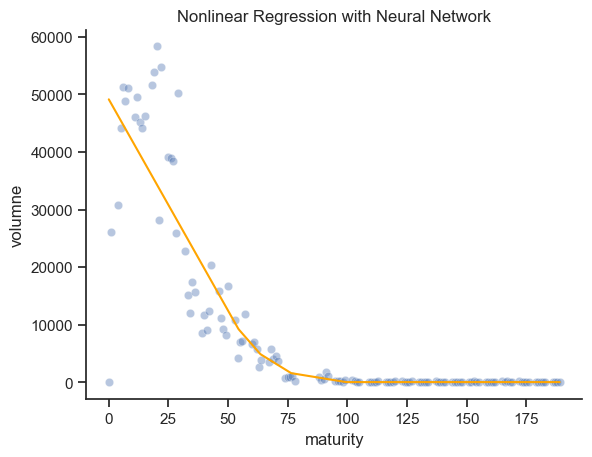

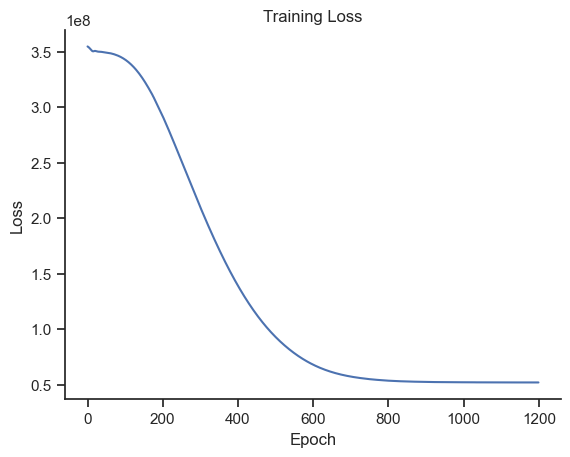

In [101]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(1, 18)  
        self.fc2 = nn.Linear(18, 1)  
    def forward(self, x):
        x1 = torch.relu(self.fc1(x))  
        x2 = self.fc2(x1)  
        return x2

x_train = torch.tensor(maturity_CU2301, dtype=torch.float)[:, None]
y_train = torch.tensor(CU2301, dtype=torch.float)[:, None]


# 创建模型实例
model = NeuralNet()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# 记录损失值
losses = []
num_epochs = 1200
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()


model.eval()
x_new = np.linspace(x_train.min(),x_train.max(), 1000)
x_new = torch.tensor(x_new, dtype=torch.float)[:, None]
with torch.no_grad():
    y_pred = model(x_new)

sns.scatterplot(x=x_train.numpy().squeeze(), y=y_train.numpy().squeeze(), alpha=0.4)
plt.plot(x_new.numpy(),  y_pred.numpy(), color='orange')
plt.xlabel('maturity')
plt.ylabel('volumne')
plt.title('Nonlinear Regression with Neural Network')
plt.show()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## then for the index options

In [102]:
id_ls = [ f'IO230{i+1}' for i in range(12)]
vol_all_IO = pd.DataFrame()
for id in tqdm(id_ls):
    options = fb.data.indexoptions.daily(instrumentid = id)
    if options is None:
        pass
    else:
        vol=options['vol'].groupby(level = 'date').sum()
        # may exist some 
        vol.index=(options.index.get_level_values('maturity')[0]-vol.index).days+1
        vol.name =  id
        vol_all_IO=pd.concat([vol_all_IO,vol],axis=1)
vol_all_IO.loc[0,:]=0
vol_all_IO=vol_all_IO.sort_index()


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:01<00:01,  4.13it/s]

Query return empty dataframe.

 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:02<00:00,  4.12it/s]

Query return empty dataframe.

Query return empty dataframe.

 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:02<00:00,  5.64it/s]

Query return empty dataframe.

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.61it/s]


In [106]:
IO2301=vol_all_IO.IO2301.dropna()
maturity_IO2301=np.array(IO2301.index)
all_data_IO=pd.concat([vol_all_IO[col] for col in vol_all_IO.columns], axis=0).dropna()
IO=all_data_IO.values
maturity_IO=np.array(all_data_IO.index)
X_train, X_test, y_train, y_test = train_test_split(maturity_IO, IO, test_size=0.3, random_state = 1)

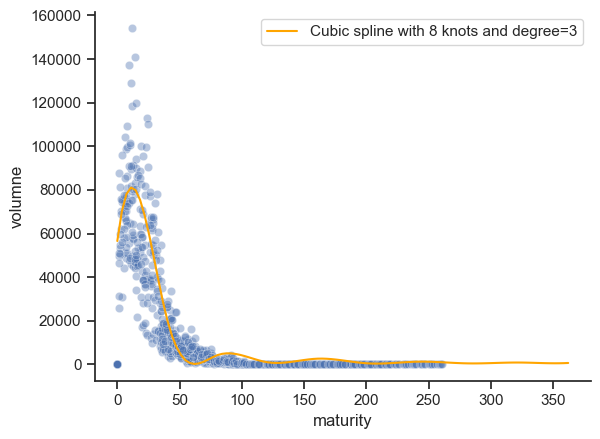

In [113]:
# i consider regression spline next
# use a spline wit 8 knots and 3 degrees ,and segment of the spline seems to be 0 to 30

reg = make_pipeline(
                    SplineTransformer(n_knots=10, degree=3), 
                    linear_model.RidgeCV(alphas=alphas)
                    )
reg.fit(X_train.reshape(-1,1), y_train)
# Create observations
x_new = np.linspace(X_test.min(),X_test.max(), 100)
# Make some predictions
pred = reg.predict(x_new.reshape(-1,1))

sns.scatterplot(x=all_data.index,y=all_data.values, alpha=0.4)

plt.plot(x_new, pred, label='Cubic spline with 10 knots and degree=3', color='orange')
plt.xlabel('maturity')
plt.ylabel('volumne')
plt.legend()

100%|████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 1368.31it/s]


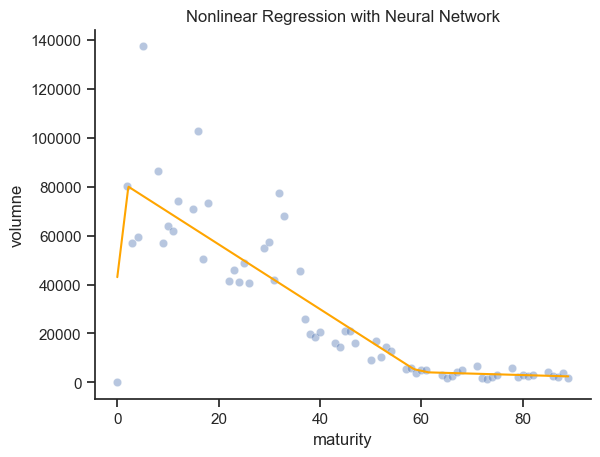

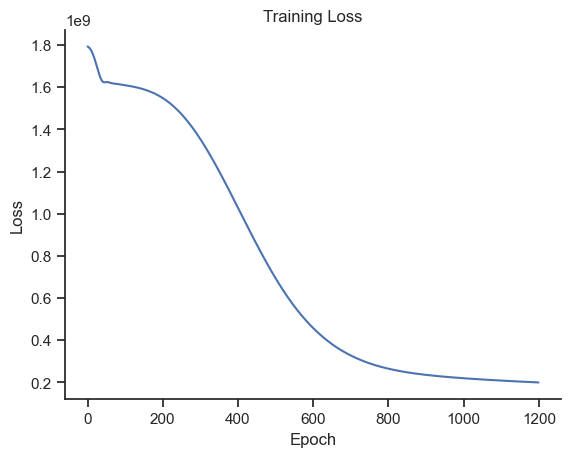

In [114]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(1, 18)  
        self.fc2 = nn.Linear(18, 1)  
    def forward(self, x):
        x1 = torch.relu(self.fc1(x))  
        x2 = self.fc2(x1)  
        return x2

x_train = torch.tensor(maturity_IO2301, dtype=torch.float)[:, None]
y_train = torch.tensor(IO2301, dtype=torch.float)[:, None]


# 创建模型实例
model = NeuralNet()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# 记录损失值
losses = []
num_epochs = 1200
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()


model.eval()
x_new = np.linspace(x_train.min(),x_train.max(), 1000)
x_new = torch.tensor(x_new, dtype=torch.float)[:, None]
with torch.no_grad():
    y_pred = model(x_new)

sns.scatterplot(x=x_train.numpy().squeeze(), y=y_train.numpy().squeeze(), alpha=0.4)
plt.plot(x_new.numpy(),  y_pred.numpy(), color='orange')
plt.xlabel('maturity')
plt.ylabel('volumne')
plt.title('Nonlinear Regression with Neural Network')
plt.show()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()